In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sp

# **Complex Data**

In this tutorial we'll look at using the Generalized Additive Models of Location Scale and Shape (GAMLSS) to model complex data that aren't suitable for the Centiles, LOESS or GP models.

## **GAMLSS**
Generalized Additive Models of Location Scale and Shape (GAMLSS) are an extension of Generalized Additive Models (GAM), which are an extension of generalized linear models. The most important feature of the GAMLSS is that they can be used to model multi-parameter distributions, meaning we can specify models for each of location, scale, shape and skewness. This flexibility allows the GAMLSS to overcome the homoskedasticity and gaussian noise assumptions of the GP & SVGP models. However, GAMLSS are advanced statistical models that require good design choices in order to produce reliable results i.e. they should not be used with off the shelf defaults. 

## **Disclaimer**
The PyNM implementation of GAMLSS is a wrapper for the R library `gamlss` and is intended to make it easy for python users to try GAMLSS for normative modeling. However, it does not make available all the utilities of the original package and we cannot guarantee the correctness of the implementation for all scenarios. In some cases it will be necessary to use the R package itself for full modeling flexibility!

In this tutorial we will implement the recommendations of the Dinga et al. 2021 [preprint](https://doi.org/10.1101/2021.06.14.448106), which we consider required reading for normative modeling with GAMLSS.

## **Example 1**
First we'll revisit the dataset from the previous tutorial to illustrate how the GAMLSS deals with heteroskedasticity and non-gaussian noise compared to the GP model.

Here we are using a dataset with:
- A single explanatory variable (age)
- Heteroskedastic variance across the explanatory variable
- Non-gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [2]:
# Define functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

def hetero_sin_noise(x):
    return 3*np.sin(0.05*x)*np.random.randn() + sp.skewnorm.rvs(a=2,size=1)[0]

def dataset_heteroskedastic(low=1,high=100,n_subs=1000,sampling='full',seed=888):
    np.random.seed(seed)
    x = sample_x(low=low,high=high,n_subs=n_subs,sampling=sampling)

    # PROB = 1/CTR = 0
    status = np.random.binomial(1,0.07,size=x.shape[0])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        s = 5 + hetero_sin_noise(x[i])

        # Random offset for probands
        s = s + status[i]*np.random.normal(0.7,1)

        score[i] = s

    df = pd.DataFrame([x,score,status],index=['age','score','status']).transpose()
    return df

In [3]:
# Create a dataset
df_het = dataset_heteroskedastic()
df_het.head()

,age,score,status
0,86.096500,6.546667,0.0
1,17.292380,4.395376,1.0
2,48.864120,4.275272,0.0
3,92.181699,4.362332,1.0
4,43.427088,6.529171,0.0


### Visualize data

<AxesSubplot: xlabel='age', ylabel='score'>

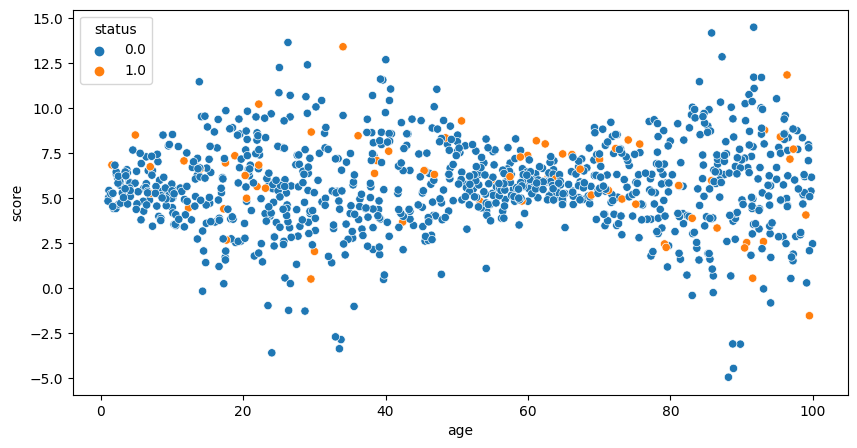

In [4]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_het)

### Fit GAMLSS model on heteroskedastic data

In [5]:
# Initialize pynm w/ data, confounds, & bin parameters
m_het = PyNM(df_het,'score','status',['age'],
                bin_width=7, bin_spacing=1)

Models will be fit on full set of controls.


In [6]:
# Run models
m_het.loess_normative_model()
m_het.gp_normative_model(length_scale_bounds='fixed',length_scale=20)
m_het.gamlss_normative_model(mu = "score ~ cs(age)", sigma = "~ cs(age,df=2)", family='NO2')

/Users/harveyaa/Documents/masters/PyNM/pynm/pynm.py:513: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/Users/harveyaa/Documents/masters/PyNM/pynm/pynm.py:519: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


GAMLSS-RS iteration 1: Global Deviance = 4074.972 


/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


GAMLSS-RS iteration 2: Global Deviance = 4074.981 
GAMLSS-RS iteration 3: Global Deviance = 4074.971 
GAMLSS-RS iteration 4: Global Deviance = 4074.97 
GAMLSS-RS iteration 5: Global Deviance = 4074.97 
new prediction 
new prediction 


As we saw in tutorial 2, the simple LOESS strategy is effective whereas the GP fails to accurately estimate the CI for the heteroskedastic data resulting in skewed deviance scores. 

Here we've added the GAMLSS model which explicitly models the variance as a function of age. This strategy captures the change in variance smoothly and results in evenly distributed deviance scores across age, neatly handling the heteroskedasticity and non-gaussian noise.

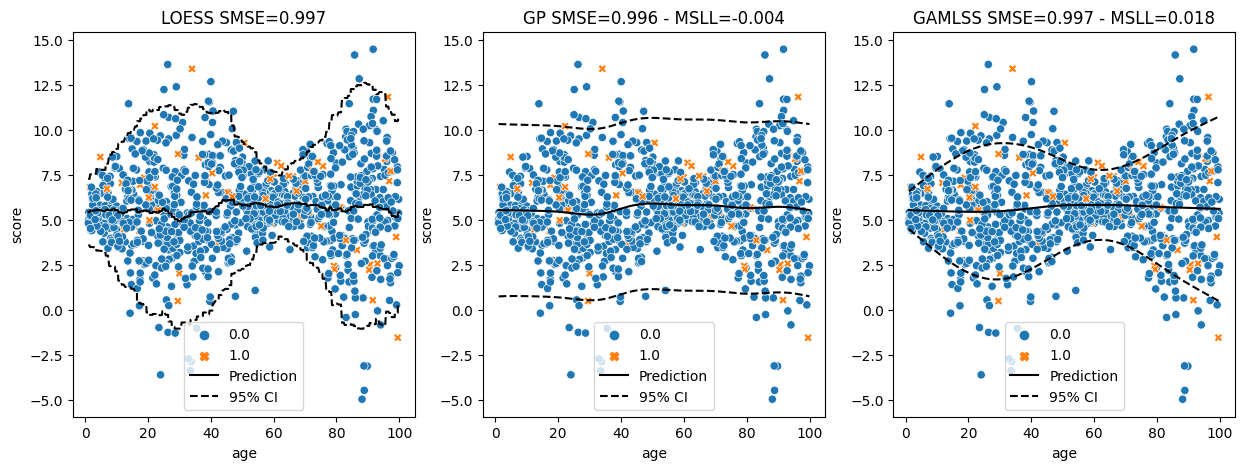

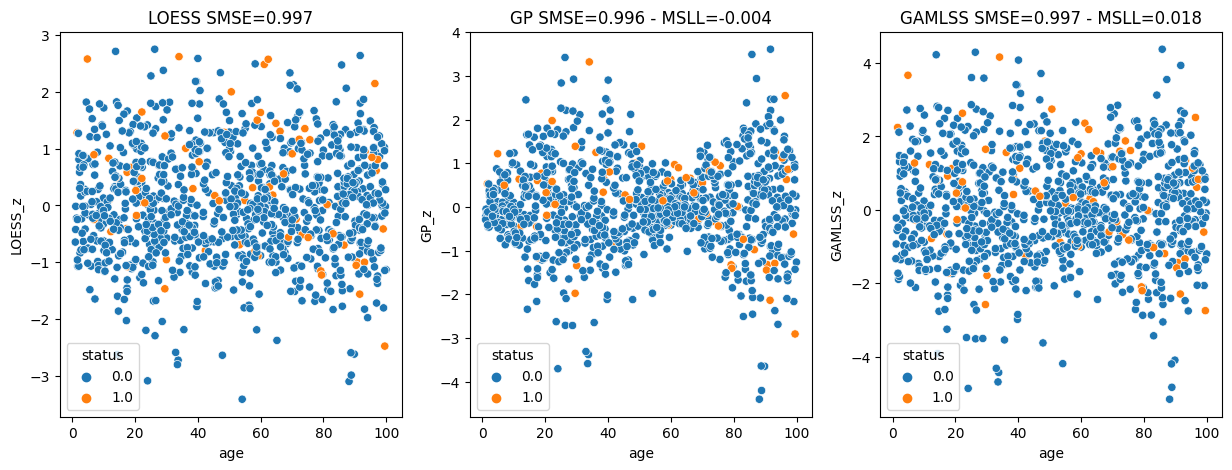

In [7]:
# Plot the data, model prediction, & 95% confidence interval
m_het.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m_het.plot_z(confound='age')

## **Example 2**
In this example we will implement the recommended model from the Dinga et al. preprint, we'll use the same dataset as we did in tutorial 2.

Here we are using a dataset with:
- Multiple confounds (explanatory variables) (age, sex & site)
- Homoskedastic variance across the explanatory variable within each site
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution
- A random offset in score for sex pulled from the gaussian distribution
- A random offset in score for site pulled from the gaussian distribution (constant for all subjects from same site)

In [8]:
def g(age, sex, offset, prob = False):
    noise = np.random.normal(0, 0.1)
    if prob:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset
    else:
        return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset

def dataset_multivariate(n_sites=5,sample_size=35,seed=650):
    np.random.seed(seed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            score = g(age, sex, site[1]['score_shift'],prob=prob)
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'status', 'age', 'score'])
    return df

In order to implement the baseline model recommended by Dinga et al. we add an additional column for sex, we also normalize the score - important for the GAMLSS model sigma parameter which is sensitive to magnitude.

In [9]:
# Create a dataset
df = dataset_multivariate()

# Add column for male
df['male'] = 1 - df['sex']

# Normalize the response variable for GAMLSS
df['score'] = (df['score'] - df['score'].mean())/df['score'].std()

df.head()

,site,sex,status,age,score,male
0,0,1,0,65.818713,0.360875,0
1,0,1,0,68.827045,-0.246850,0
2,0,0,0,61.660016,-0.145683,1
3,0,0,0,66.886592,0.436059,1
4,0,0,0,55.738248,-0.445415,1


**Note:** It is important to check the `dtypes` of all the columns in the input DataFrame before feeding it to the PyNM object when using the GAMLSS model. The implementation of GAMLSS in PyNM is a wrapper for the R library `gamlss`, so before the model can be fit the `pandas` DataFrame gets converted by `rpy2` into an R DataFrame. The conversion can be finnicky, and works best for standard dtypes (`float`,`int`,`str`). Specifically, columns of type `object` and `uint8` won't be properly converted.

If you get an error along the lines of "XXX has no attribute encode" when running the GAMLSS check the `dtypes`!

In [10]:
df.dtypes

site        int64
sex         int64
status      int64
age       float64
score     float64
male        int64
dtype: object

### Visualize data

Text(0.5, 1.0, 'By sex')

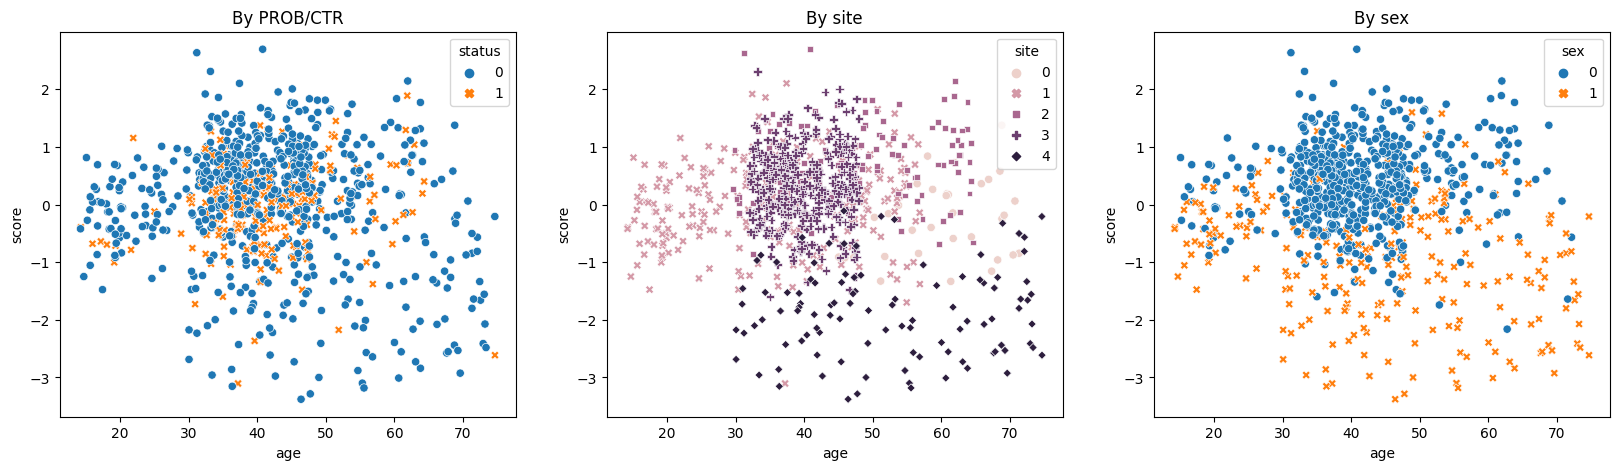

In [11]:
fig,ax = plt.subplots(1,3,figsize=(20,5))

sns.scatterplot(data=df, x='age', y='score', hue='status', style='status',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

### Fit GAMLSS

In [12]:
# Initialize pynm w/ data, confounds, & bin parameters
m = PyNM(df,'score','status',['age','c(sex)','c(site)'])

Models will be fit on full set of controls.


Here we've implemented the recommended baseline model from the Dinga et al preprint:

![image3](image3.jpg)

In [13]:
# Run model
m.gamlss_normative_model(mu = 'score ~ ps(age*sex) + ps(age*male) + random(as.factor(site))',
                        sigma = '~ ps(age)+ random(as.factor(site))')

/Users/harveyaa/miniconda3/envs/pynm/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


GAMLSS-RS iteration 1: Global Deviance = 1403.889 
GAMLSS-RS iteration 2: Global Deviance = 1273.816 
GAMLSS-RS iteration 3: Global Deviance = 1226.807 
GAMLSS-RS iteration 4: Global Deviance = 1210.348 
GAMLSS-RS iteration 5: Global Deviance = 1204.135 
GAMLSS-RS iteration 6: Global Deviance = 1201.705 
GAMLSS-RS iteration 7: Global Deviance = 1200.698 
GAMLSS-RS iteration 8: Global Deviance = 1200.277 
GAMLSS-RS iteration 9: Global Deviance = 1200.09 
GAMLSS-RS iteration 10: Global Deviance = 1200.008 
GAMLSS-RS iteration 11: Global Deviance = 1199.969 
GAMLSS-RS iteration 12: Global Deviance = 1199.954 
GAMLSS-RS iteration 13: Global Deviance = 1199.948 
GAMLSS-RS iteration 14: Global Deviance = 1199.946 
GAMLSS-RS iteration 15: Global Deviance = 1199.945 
GAMLSS-RS iteration 16: Global Deviance = 1199.944 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 
new prediction 
New way of prediction in random()  (starting from GAMLSS version 5.0-6) 


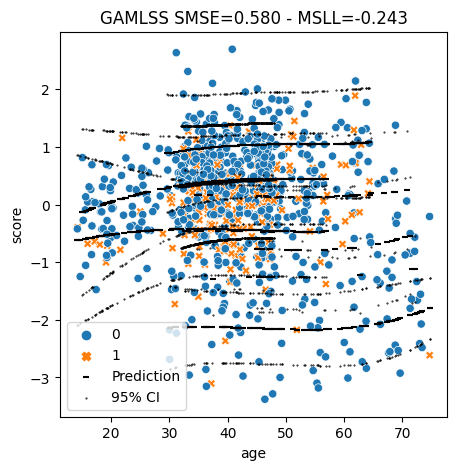

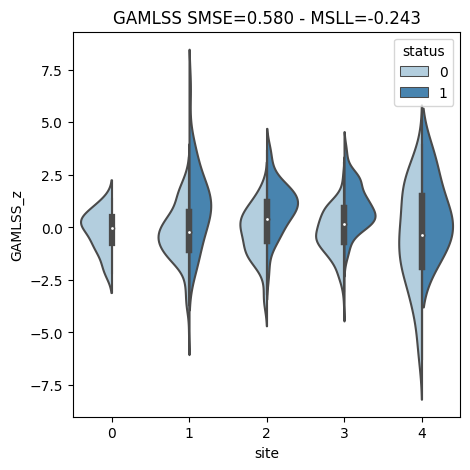

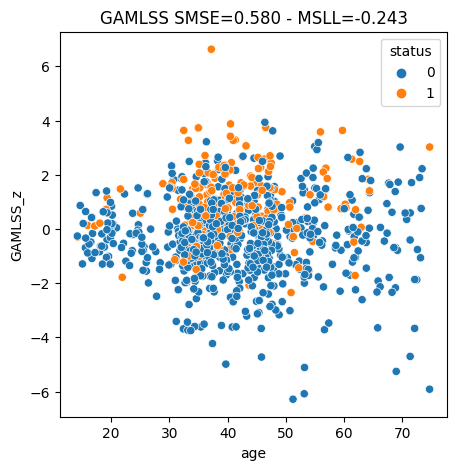

In [14]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z(confound='site')
m.plot_z(confound='age')

## **Full GAMLSS model outputs**
We can explore the full outputs of the GAMLSS model by accessing the `data` attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

We won't look at the rest of the columns in `data` since they were covered in tutorials 1 & 2.

In [15]:
GAMLSS_cols = [col for col in m.data.columns if 'GAMLSS' in col]
m.data[GAMLSS_cols].head()

,GAMLSS_pred,GAMLSS_sigma,GAMLSS_residuals,GAMLSS_z
0,-0.684107,-0.544221,1.044982,-1.920142
1,-0.613739,-0.533668,0.366889,-0.687485
2,0.150748,-0.545436,-0.296431,0.543475
3,0.193192,-0.541520,0.242867,-0.448491
4,0.134617,-0.533672,-0.580033,1.086872


### Description of columns
- GAMLSS_pred
    - Prediction of the GAMLSS model (mean of predictive distribution).
- GAMLSS_sigma
    - Sigma parameter of the GAMLSS model.
- GAMLSS_residuals
    - Difference between actual value of score and GAMLSS_pred.
- GAMLSS_z
    - GAMLSS_residuals / GAMLSS_sigma.
    - **Warning**: this assumes that GAMLSS_sigma is equivalent to the standard deviation, this is NOT true in all cases and GAMLSS_z should be treated with caution.

## **Summary**
- GAMLSS can model multi-parameter distributions, making them very flexible.
    - We can specify models for each of location, scale, shape and skewness.
- GAMLSS can overcome the homoskedasticity and gaussian noise assumptions of the GP & SVGP models.
- GAMLSS are advanced statistical models that must be used with caution.
    - Good design choices required, cannot rely on off the shelf defaults.
- GAMLSS are sensitive to the magnitude of the data.
- The PyNM implementation is a wrapper for the R `gamlss` library.
    - Need to make sure the input `DataFrame` for the PyNM object has correct `dtypes` before using GAMLSS.
- The sigma parameter of the GAMLSS is not always equivalent to the standard deviation, `GAMLSS_z` must be treated with caution as a result.

## **Resources**
- Dinga et al. 2021 [Normative modeling of neuroimaging data using generalized additive models of location scale and shape](https://doi.org/10.1101/2021.06.14.448106)
- R `gamlss` package [documentation](https://cran.r-project.org/web/packages/gamlss/gamlss.pdf)

### **Next up:** Model selection using cross-validation!